In [2]:
import pandas as pd
pd.options.display.max_columns=200
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st
from matplotlib import gridspec
from statannot import add_stat_annotation
from matplotlib import gridspec

### Important!

-- This notebook uses the aggregated list of predicted neoapitopes per sample for the Hartwig samples. This data is avaliable as part of the routine output generated from the Hartwig Medical Foundation pipeline. The tool Neo is  integrated into the tumor analytical pipeline (https://github.com/hartwigmedical/hmftools/tree/master/neo)

-- This tool consider potential neoepitopes from both point mutations and indels as well as gene-fusion events. See Supplementary Note 2 for further details about the Neoepitope priotiziation pipeline. 

In [3]:
df_met = pd.read_csv("../results/data/processed_hmf_escape_info.tsv.gz",sep="\t") # load information of LOH in Hartwig, Supp. Table 4

/home/fran/miniconda3/envs/global/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (16,17,19,20,142) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### We contatenated the sample-specific report of neoepitopes into one big aggregated file

In [ ]:
aggregated_neo_path="/home/fran/Documents/cuppen/HPC/tunnel//cuppen/projects/P0020_genetics_immune_escape/large_scale_primary_met/analysis/results/neopeptides/

In [3]:
df = pd.read_csv(f"{aggregated_neo_path}/report_neoepitopes_hmf.tsv.gz",sep="\t")
df.set_index("SampleId",inplace=True)

/home/fran/miniconda3/envs/global/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (31) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Gather information about samples with LOH and which specific alleles are lost across Hartwig samples

In [5]:
loh=df_met[df_met["loh_lilac"]]
d_data_full={"HLA-A":{},"HLA-B":{},"HLA-C":{}}
for i,r in tqdm(loh.iterrows()):
    sample=r["sample_id"]
    for x in ["A","B","C"]:
        if r[f"{x}1"] == r[f"{x}2"]: # not homozygous
            continue
        if (r[f"{x}1_CN"] < 0.3 and r[f"{x}2_CN"] > 0.7) and r[f"{x}2_MUT"] == 0:  # is not mutated the alternate allele
            d_data_full[f"HLA-{x}"][sample] = (r[f"{x}1"].replace("*","").replace(":",""),r[f"{x}2"].replace("*","").replace(":","")) # loss, kept
        elif r[f"{x}2_CN"] < 0.3 and r[f"{x}1_CN"] > 0.7 and r[f"{x}1_MUT"] == 0: # is not mutated the alternate allele
            d_data_full[f"HLA-{x}"][sample] = (r[f"{x}2"].replace("*","").replace(":",""),r[f"{x}1"].replace("*","").replace(":","")) # loss, kept
    
        


783it [00:00, 2926.85it/s]


### Only non-focal cases

In [6]:
loh=df_met[(df_met["loh_lilac"])&(df_met["loh_nonfocal"].str.contains("HLA",na=False))]
d_data_nonfocal={"HLA-A":{},"HLA-B":{},"HLA-C":{}}
for i,r in tqdm(loh.iterrows()):
    sample=r["sample_id"]
    for x in ["A","B","C"]:
        if r[f"{x}1"] == r[f"{x}2"] or not f"HLA-{x}" in r["loh_nonfocal"]: # not homozygous
            continue
        if (r[f"{x}1_CN"] < 0.3 and r[f"{x}2_CN"] > 0.7) and r[f"{x}2_MUT"] == 0:  # kept intact, not mutated
            d_data_nonfocal[f"HLA-{x}"][sample] = (r[f"{x}1"].replace("*","").replace(":",""),r[f"{x}2"].replace("*","").replace(":","")) # loss, kept
        elif r[f"{x}2_CN"] < 0.3 and r[f"{x}1_CN"] > 0.7 and r[f"{x}1_MUT"] == 0: # kept intact, not mutated
            d_data_nonfocal[f"HLA-{x}"][sample] = (r[f"{x}2"].replace("*","").replace(":",""),r[f"{x}1"].replace("*","").replace(":","")) # loss, kept
    
        


174it [00:00, 2193.90it/s]


### Only focal cases

In [7]:
loh=df_met[(df_met["loh_lilac"])&(df_met["loh_focal"].str.contains("HLA",na=False))]
d_data_focal={"HLA-A":{},"HLA-B":{},"HLA-C":{}}
for i,r in tqdm(loh.iterrows()):
    sample=r["sample_id"]
    for x in ["A","B","C"]:
        if r[f"{x}1"] == r[f"{x}2"] or not f"HLA-{x}" in r["loh_focal"]: # not homozygous
            continue
        if (r[f"{x}1_CN"] < 0.3 and r[f"{x}2_CN"] > 0.7) and r[f"{x}2_MUT"] == 0:  # kept intact, not mutated
            d_data_focal[f"HLA-{x}"][sample] = (r[f"{x}1"].replace("*","").replace(":",""),r[f"{x}2"].replace("*","").replace(":","")) # loss, kept
        elif r[f"{x}2_CN"] < 0.3 and r[f"{x}1_CN"] > 0.7 and r[f"{x}1_MUT"] == 0: # kept intact, not mutated
            d_data_focal[f"HLA-{x}"][sample] = (r[f"{x}2"].replace("*","").replace(":",""),r[f"{x}1"].replace("*","").replace(":","")) # loss, kept
    
        


609it [00:00, 4306.75it/s]


# Function to perform the analysis 

In [11]:
def run_loh_test_ratio(d_data,q):
    l=[]
    d=q.groupby(["SampleId","Allele"]).agg({"Peptide":"count"}).to_dict()["Peptide"] # count number of peptides per allele
    for allele in ["HLA-A","HLA-B","HLA-C"]:
        for sample in d_data[allele]:
            loss,kept = d_data[allele][sample] # get the info of alleles and the numbers of loss and kept neoepitopes
            loss_neo=d.get((sample,loss),0)
            kept_neo=d.get((sample,kept),0)
            if loss_neo + kept_neo ==0: # if there are not neoepitopes for neither of the alleles the test does not make sense... 
                continue
            is_a1=np.random.randint(low=0,high=2) # randmoly select as allele1 one of the alleles (just for visualization)
            if  is_a1 == 0:
                loh=True
                ratio_normalized = (loss_neo) / (loss_neo + kept_neo)
            else:
                loh=False
                ratio_normalized = (kept_neo) / (loss_neo + kept_neo)
                
            l.append([sample,allele,loss_neo,kept_neo,ratio_normalized,1-ratio_normalized,loh,np.random.randint(low=0,high=2)==0])
    df_a = pd.DataFrame(l,columns=["sampleId","gene","loss_neo","kept_neo","norm_ratio","norm_alt_ratio","loh","loh_random"]) 
    return df_a
thresholds=list([0.35,0.40,0.45,0.5,0.55,0.6,0.65,1.0])
thresholds_cat = ["[0.0,0.35)","[0.35,0.4)","[0.4,0.45)","[0.45,0.5)","[0.5,0.55)","[0.55,0.6)","[0.6,0.65)","[0.65,1.0)"]
def get_bin(k):
    for i,v in enumerate(thresholds[0:]):
        if k < v:
            return i
    return i
def compute_prevalence_mean(k):
    return  np.sum(k)/len(k)


## Perform boostrapping for the LOH of HLA-I aggregated Hartwig samples 

In [12]:
l=[]
q=df[(df["LikelihoodRank"]<0.02)&(df["ExpLikelihoodRank"]<0.02)] # select neoepitopes, only presented
for N in tqdm(range(100)): # 100 boostraps
    df_ = run_loh_test_ratio(d_data_full,q.sample(frac=0.75,random_state=N)) # select 75% of the cohort
    df_["iteration"] = N
    l.append(df_)
    
df_a = pd.concat(l)
df_a.to_csv("../results/data/raw_data_loh_randomizations_hmf.tsv.gz",sep="\t",index=False,compression="gzip") # to reproduce the visualization

100%|██████████| 100/100 [32:42<00:00, 19.63s/it]


0 4.933232339460506e-18
1 1.338288307848012e-10
2 2.1668956403206167e-12
3 1.6977776794591644e-10
4 4.611178320559122e-09
5 6.295079196975035e-16
6 1.8485419137908334e-10
7 1.3221595022070932e-23


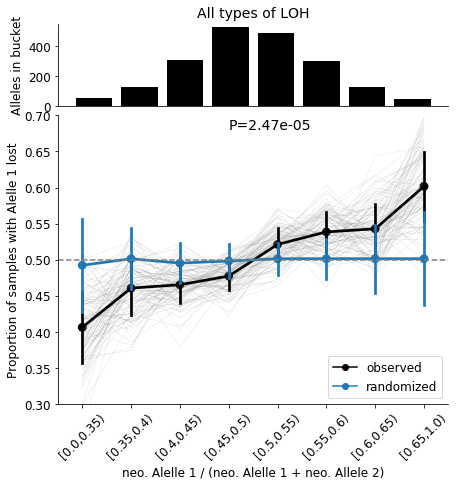

In [13]:
df_a = pd.read_csv("../results/data/raw_data_loh_randomizations_hmf.tsv.gz",sep="\t",compression="gzip")
df_a["bin"] = df_a.apply(lambda row: get_bin(row["norm_ratio"]),axis=1)
df_g=df_a.groupby(["iteration","bin"]).agg(mean_prev = ("loh",compute_prevalence_mean))
df_c=df_a.groupby(["iteration","bin"]).agg(count_v = ("loh","count"))
df_g_control=df_a.groupby(["iteration","bin"]).agg(mean_prev = ("loh_random",compute_prevalence_mean))
fig,ax = plt.subplots(figsize=(7,7))
gs = gridspec.GridSpec(figure=fig, ncols=1, nrows=2, height_ratios=[2,7])
gs.update(hspace=0.05, wspace=0.0)
# distplot
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax0.set_xticks([])
ax0.set_xticklabels([])
ax0.set_ylabel("Alleles in bucket",fontsize=12)
ax0.set_title("All types of LOH",fontsize=14)
ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)
ax0.bar(x=df_c.loc[0].index,height=df_c.loc[0]["count_v"].values,color="black")

# point plot
for i in range(100):
    ax1.plot(df_g.loc[i],color="grey",lw=0.1)
sns.pointplot(data=df_g.reset_index(),x="bin",y="mean_prev",color="black",ci="sd")
sns.pointplot(data=df_g_control.reset_index(),x="bin",y="mean_prev",color="#1f78b4",ci="sd")
    
e=df_g.reset_index()
e1=df_g_control.reset_index()
_,p=st.ks_2samp(e["mean_prev"].values,e1["mean_prev"].values)
ax1.annotate(xy=(3,0.68),s="P={:.2e}".format(p),fontsize=14)

for i in range(0,8):
    _,p=st.mannwhitneyu(e[e["bin"]==i]["mean_prev"].values,e1[e1["bin"]==i]["mean_prev"].values)
    print (i,p)
    text = ""
    if p < 0.01:
        text="**"
    #ax1.annotate(xy=(i,0.7),s=text,fontsize=14)

ax1.set_xticks(list(range(len(thresholds))))
ax1.set_xticklabels(thresholds_cat,rotation=45)
ax1.axhline(0.5,ls="--",color="grey")
ax1.set_ylabel("Proportion of samples with Alelle 1 lost",fontsize=12)
ax1.set_xlabel("neo. Alelle 1 / (neo. Alelle 1 + neo. Allele 2)",fontsize=12)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax0.tick_params(axis='both', which='major', labelsize=12)
ax1.tick_params(axis='both', which='major', labelsize=12)
markers = [plt.Line2D([0,0],[0,0],color="black", marker='o', ),plt.Line2D([0,0],[0,0],color="#1f78b4",  marker='o')]
ax1.legend(markers, ["observed","randomized"], numpoints=1,fontsize=12,loc="lower right")
ax1.set_ylim(0.3,0.7)
plt.savefig(f'../results/figures/figure5/LOH_neo_effect_bucket_hmf.pdf', dpi=800,bbox_inches="tight")

## Perform multiple iterations for the Hartwig samples with focal LOH of HLA-I

In [14]:
l=[]
q=df[(df["LikelihoodRank"]<0.02)&(df["ExpLikelihoodRank"]<0.02)]
for N in tqdm(range(100)):
    df_ = run_loh_test_ratio(d_data_focal,q.sample(frac=0.75,random_state=N))
    df_["iteration"] = N
    l.append(df_)
    
df_a = pd.concat(l)
df_a.to_csv("../results/data/raw_data_loh_randomizations_focal_hmf.tsv.gz",sep="\t",index=False,compression="gzip") # to reproduce the visualization

100%|██████████| 100/100 [31:59<00:00, 19.20s/it]


0 4.715909955509184e-22
1 1.8047708183871946e-13
2 3.0305284511111794e-20
3 3.62709646049501e-12
4 1.5189850158681875e-12
5 2.8001966884278735e-20
6 1.2801787726360552e-13
7 7.046937324992043e-27


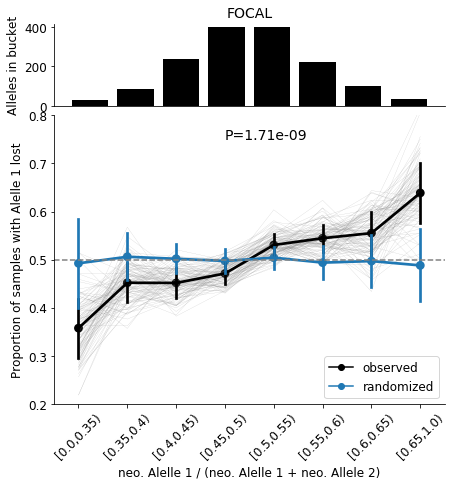

In [15]:
df_a = pd.read_csv("../results/data/raw_data_loh_randomizations_focal_hmf.tsv.gz",sep="\t",compression="gzip")
df_a["bin"] = df_a.apply(lambda row: get_bin(row["norm_ratio"]),axis=1)
df_g=df_a.groupby(["iteration","bin"]).agg(mean_prev = ("loh",compute_prevalence_mean))
df_c=df_a.groupby(["iteration","bin"]).agg(count_v = ("loh","count"))
df_g_control=df_a.groupby(["iteration","bin"]).agg(mean_prev = ("loh_random",compute_prevalence_mean))
fig,ax = plt.subplots(figsize=(7,7))
gs = gridspec.GridSpec(figure=fig, ncols=1, nrows=2, height_ratios=[2,7])
gs.update(hspace=0.05, wspace=0.0)
# distplot
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax0.set_xticks([])
ax0.set_xticklabels([])
ax0.set_ylabel("Alleles in bucket",fontsize=12)
ax0.set_title("FOCAL",fontsize=14)
ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)
ax0.bar(x=df_c.loc[0].index,height=df_c.loc[0]["count_v"].values,color="black")

# point plot
for i in range(100):
    ax1.plot(df_g.loc[i],color="grey",lw=0.1)
sns.pointplot(data=df_g.reset_index(),x="bin",y="mean_prev",color="black",ci="sd")
sns.pointplot(data=df_g_control.reset_index(),x="bin",y="mean_prev",color="#1f78b4",ci="sd")
    
e=df_g.reset_index()
e1=df_g_control.reset_index()

_,p=st.ks_2samp(e["mean_prev"].values,e1["mean_prev"].values)
ax1.annotate(xy=(3,0.75),s="P={:.2e}".format(p),fontsize=14)

for i in range(0,8):
    _,p=st.mannwhitneyu(e[e["bin"]==i]["mean_prev"].values,e1[e1["bin"]==i]["mean_prev"].values)
    print (i,p)
    text = ""
    if p < 0.01:
        text="**"
    #ax1.annotate(xy=(i,0.7),s=text,fontsize=14)

ax1.set_xticks(list(range(len(thresholds))))
ax1.set_xticklabels(thresholds_cat,rotation=45)
ax1.axhline(0.5,ls="--",color="grey")
ax1.set_ylabel("Proportion of samples with Alelle 1 lost",fontsize=12)
ax1.set_xlabel("neo. Alelle 1 / (neo. Alelle 1 + neo. Allele 2)",fontsize=12)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax0.tick_params(axis='both', which='major', labelsize=12)
ax1.tick_params(axis='both', which='major', labelsize=12)
markers = [plt.Line2D([0,0],[0,0],color="black", marker='o', ),plt.Line2D([0,0],[0,0],color="#1f78b4",  marker='o')]
ax1.legend(markers, ["observed","randomized"], numpoints=1,fontsize=12,loc="lower right")
ax1.set_ylim(0.2,0.8)
plt.savefig(f'../results/figures/figure5/LOH_neo_effect_bucket_hmf_focal.pdf', dpi=800,bbox_inches="tight")

## Perform multiple iterations for the Hartwig samples with non-focal LOH of HLA-I

In [18]:
l=[]
q=df[(df["LikelihoodRank"]<0.02)&(df["ExpLikelihoodRank"]<0.02)]
for N in tqdm(range(100)):
    df_ = run_loh_test_ratio(d_data_nonfocal,q.sample(frac=0.75,random_state=N))
    df_["iteration"] = N
    l.append(df_)
    
df_a = pd.concat(l)
df_a.to_csv("../results/data/raw_data_loh_randomizations_nonfocal_hmf.tsv.gz",sep="\t",index=False,compression="gzip") # to reproduce the visualization

100%|██████████| 100/100 [34:51<00:00, 20.92s/it]


0 0.2790102778181546
1 0.17557673334352047
2 0.2895510644293429
3 0.07451995642230642
4 0.3034998971170106
5 0.450412499541171
6 0.016143964271921146
7 0.018539830351522783


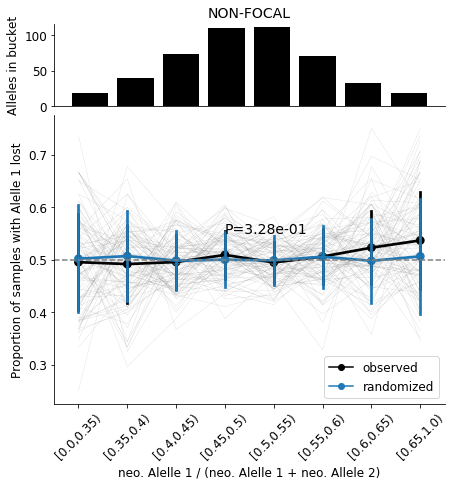

In [19]:
df_a = pd.read_csv("../results/data/raw_data_loh_randomizations_nonfocal_hmf.tsv.gz",sep="\t",compression="gzip")

df_a["bin"] = df_a.apply(lambda row: get_bin(row["norm_ratio"]),axis=1)
df_g=df_a.groupby(["iteration","bin"]).agg(mean_prev = ("loh",compute_prevalence_mean))
df_c=df_a.groupby(["iteration","bin"]).agg(count_v = ("loh","count"))
df_g_control=df_a.groupby(["iteration","bin"]).agg(mean_prev = ("loh_random",compute_prevalence_mean))
fig,ax = plt.subplots(figsize=(7,7))
gs = gridspec.GridSpec(figure=fig, ncols=1, nrows=2, height_ratios=[2,7])
gs.update(hspace=0.05, wspace=0.0)
# distplot
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax0.set_xticks([])
ax0.set_xticklabels([])
ax0.set_ylabel("Alleles in bucket",fontsize=12)
ax0.set_title("NON-FOCAL",fontsize=14)
ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)
ax0.bar(x=df_c.loc[0].index,height=df_c.loc[0]["count_v"].values,color="black")

# point plot
for i in range(100):
    ax1.plot(df_g.loc[i],color="grey",lw=0.1)
sns.pointplot(data=df_g.reset_index(),x="bin",y="mean_prev",color="black",ci="sd")
sns.pointplot(data=df_g_control.reset_index(),x="bin",y="mean_prev",color="#1f78b4",ci="sd")
    
e=df_g.reset_index()
e1=df_g_control.reset_index()
_,p=st.ks_2samp(e["mean_prev"].values,e1["mean_prev"].values)
ax1.annotate(xy=(3,0.55),s="P={:.2e}".format(p),fontsize=14)

for i in range(0,8):
    _,p=st.mannwhitneyu(e[e["bin"]==i]["mean_prev"].values,e1[e1["bin"]==i]["mean_prev"].values)
    print (i,p)
    text = ""
    if p < 0.01:
        text="**"
    #ax1.annotate(xy=(i,0.5),s=text,fontsize=14)

ax1.set_xticks(list(range(len(thresholds))))
ax1.set_xticklabels(thresholds_cat,rotation=45)
ax1.axhline(0.5,ls="--",color="grey")
ax1.set_ylabel("Proportion of samples with Alelle 1 lost",fontsize=12)
ax1.set_xlabel("neo. Alelle 1 / (neo. Alelle 1 + neo. Allele 2)",fontsize=12)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax0.tick_params(axis='both', which='major', labelsize=12)
ax1.tick_params(axis='both', which='major', labelsize=12)
markers = [plt.Line2D([0,0],[0,0],color="black", marker='o', ),plt.Line2D([0,0],[0,0],color="#1f78b4",  marker='o')]
ax1.legend(markers, ["observed","randomized"], numpoints=1,fontsize=12,loc="lower right")
plt.savefig(f'../results/figures/figure5/LOH_neo_effect_bucket_hmf_nonfocal.pdf', dpi=800,bbox_inches="tight")